# 方法

## 数据预处理
在这一部分， 你需要清晰记录你所有必要的数据预处理步骤。在前一个部分所描述的数据的异常或特性在这一部分需要被更正和处理。需要考虑的问题有：
- _如果你选择的算法需要进行特征选取或特征变换，你对此进行记录和描述了吗？_
- _**数据的探索**这一部分中提及的异常和特性是否被更正了，对此进行记录和描述了吗？_
- _如果你认为不需要进行预处理，你解释个中原因了吗？_


准备text8语料库，本项目使用text8作为词向量训练的语料库。打开文件可以看到text8已经是整理过的，干净的单词列表，标点符号已经清理干净。可以直接使用，不需要进一步处理。

In [1]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
#import problem_unittests as tests
import tarfile
from zipfile import ZipFile

#text8, 本项目使用text8作词向量训练
text8 = "text8.zip"
text8_path = 'text8'
#本项目使用20新闻语料包进行文档分类
news20 = "20news-bydate.tar.gz"
news20_path = 'news20'
#保存模型目录
model_path = 'models'
#临时文件目录
temp_path = "temp"
#log 目录
log_path = "log"

#数据下载代码部分参考udacity图形分类课程.
#https://classroom.udacity.com/nanodegrees/nd009-cn-advanced/parts/7388ea26-95d9-4b8c-8c1b-d7b7fcb8ccdd/modules/8ed0abc9-7629-4704-9056-0a4e9d7e62e7/lessons/30f8ea4b-4e89-4239-9fd3-30ce039d3e55/concepts/73e2eeab-23e2-4659-a964-be3df7818ac4
class DLProgress(tqdm):
    last_block = 0
    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile('text8.zip'):
    with DLProgress(
        unit='B', unit_scale=True, miniters=1, desc='text8') as pbar:
        urlretrieve(
            'http://mattmahoney.net/dc/text8.zip',
            'text8.zip',
            pbar.hook)

if not isdir(text8_path):
    with ZipFile('text8.zip') as zf:
        zf.extractall(path = text8_path)
        zf.close()

fh = open(text8_path + '/text8')        
print (fh.read(1000))
#tests.test_folder_path(cifar10_dataset_folder_path)

 anarchism originated as a term of abuse first used against early working class radicals including the diggers of the english revolution and the sans culottes of the french revolution whilst the term is still used in a pejorative way to describe any act that used violent means to destroy the organization of society it has also been taken up as a positive label by self defined anarchists the word anarchism is derived from the greek without archons ruler chief king anarchism as a political philosophy is the belief that rulers are unnecessary and should be abolished although there are differing interpretations of what this means anarchism also refers to related social movements that advocate the elimination of authoritarian institutions particularly the state the word anarchy as most anarchists use it does not imply chaos nihilism or anomie but rather a harmonious anti authoritarian society in place of what are regarded as authoritarian political structures and coercive economic instituti

text8 文档长度:17005208
text8一共有253854个单词
[('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764), ('in', 372201), ('a', 325873), ('to', 316376), ('zero', 264975), ('nine', 250430), ('two', 192644), ('is', 183153), ('as', 131815), ('eight', 125285), ('for', 118445), ('s', 116710), ('five', 115789), ('three', 114775), ('was', 112807), ('by', 111831), ('that', 109510), ('four', 108182), ('six', 102145), ('seven', 99683), ('with', 95603), ('on', 91250), ('are', 76527), ('it', 73334), ('from', 72871), ('or', 68945), ('his', 62603)]


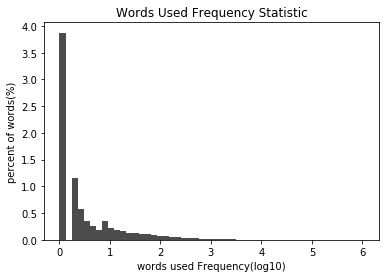

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display # 使得我们可以对DataFrame使用display()函数
from pandas import Series, DataFrame
import math

# 设置以内联的形式显示matplotlib绘制的图片（在notebook中显示更美观）
%matplotlib inline
import re
# 分析tex8词库内容
def ana_text8():
    total_data = open(text8_path + '/text8').read()
    words_raw = [word for word in re.split(r'\W+', total_data)] 
    text8_len = len(words_raw)
    print("text8 文档长度:{}".format(len(words_raw)) )
    word_dic = {}
    for word in words_raw:
        if word == "":
            continue
        if word in word_dic:
            word_dic[word] +=1
        else:
            word_dic[word] = 1
    print("text8一共有{}个单词".format(len(word_dic)))
    freq_word = Series((list(word_dic.values())))
    freq_word_log10 = np.log10(freq_word)
    fig, axes = plt.subplots(1,1)
    freq_word_log10.plot(kind="hist", bins = 50, normed = True, color = "k", alpha = 0.7)
    axes.set_title("Words Used Frequency Statistic")
    axes.set_xlabel("words used Frequency(log10)")
    axes.set_ylabel("percent of words(%)")
    #获取最常用的10个单词
    word_sorted = sorted(word_dic.items(), key=lambda a : a[1], reverse = True)
    print(word_sorted[:30])
ana_text8()    

准备分类文本数据，本项目使用经典的20类新闻包，里面大约有20000条新闻，比较均衡地分成了20类。打开文件可以看到，这些文本数据是原始新闻数据，包含标点符号等数据，需要进行预处理。本项目
* 大小写，统一转换成小写字符。虽然大写的文本往往包含特殊含义，但也有部分纯粹语法要求，没有实际意义，在本项目文档分类中，暂不考虑这部分的影响。
* 标点符号，本项目去掉所有的标点符。标点符号在文档表达中有其特定的意义，但本文档中只考虑单词的意义对文档的影响，不考虑标点符号。
* 数字，去除所有独立的数字，但字符与数字的结合认为是一个单词。如"abc 123"中"123"会被去除，"abc123"则会认作一个单词。

In [3]:
#解压20类新闻报
import gzip
if not isdir(news20_path):        
    gz = gzip.GzipFile(news20)
    tarfilename = news20.replace(".gz", "")
    open(tarfilename, "wb").write(gz.read())
    with tarfile.TarFile(tarfilename) as mytar:
        mytar.extractall(news20_path)
        mytar.close()
    gz.close()    


分别读取nes20中train和test数据，保存到变量，并以其中新闻目录作为文档分类的目标值
* document_train_x, 训练文档初始数据
* document_train_y，训练文档目标分类
* document_test_x， 测试文档初始数据
* document_test_y， 测试文档目标分类


In [4]:
import os
assert isdir(news20_path), "The news20 is not availaible"

#遍历当前目录，获取路径/目录/文件名
news_path_train = news20_path + '/20news-bydate-train'
news_path_test = news20_path + '/20news-bydate-test'

def get_x_y():
    document_train_x = []
    document_train_x_filename = []
    document_train_y = []
    document_test_x = []
    document_test_x_filename = []
    document_test_y = []
    #读取train数据
    for dirs in os.listdir(news_path_train ):
        subdir = news_path_train + '/' + dirs
        for file in os.listdir(subdir):
            file_path = subdir + '/' + file
            if isfile(file_path):
                data = open(file_path, 'rb').read()
                document_train_x_filename.append(file)
                document_train_x.append(data)
                document_train_y.append(dirs)
    #读取test数据
    for dirs in os.listdir(news_path_test ):
        subdir = news_path_test + '/' + dirs
        for file in os.listdir(subdir):
            file_path = subdir + '/' + file
            if isfile(file_path):
                data = open(file_path, 'rb').read()
                document_test_x_filename.append(file)
                document_test_x.append(data)
                document_test_y.append(dirs)
    return  document_train_x, document_train_y, document_test_x, document_test_y

In [5]:
#数据分析
document_train_x, document_train_y, document_test_x, document_test_y = get_x_y()
print(document_test_x[:1])
print(document_train_y[:1])
print("新闻20训练集一共有文档{}".format(len(document_train_x)))
print("新闻20测试集一共有文档{}".format(len(document_test_x)))

[b'From: decay@cbnewsj.cb.att.com (dean.kaflowitz)\nSubject: Re: about the bible quiz answers\nOrganization: AT&T\nDistribution: na\nLines: 18\n\nIn article <healta.153.735242337@saturn.wwc.edu>, healta@saturn.wwc.edu (Tammy R Healy) writes:\n> \n> \n> #12) The 2 cheribums are on the Ark of the Covenant.  When God said make no \n> graven image, he was refering to idols, which were created to be worshipped. \n> The Ark of the Covenant wasn\'t wrodhipped and only the high priest could \n> enter the Holy of Holies where it was kept once a year, on the Day of \n> Atonement.\n\nI am not familiar with, or knowledgeable about the original language,\nbut I believe there is a word for "idol" and that the translator\nwould have used the word "idol" instead of "graven image" had\nthe original said "idol."  So I think you\'re wrong here, but\nthen again I could be too.  I just suggesting a way to determine\nwhether the interpretation you offer is correct.\n\n\nDean Kaflowitz\n']
['alt.atheism']
新闻

文档预处理，采用refine_corpus函数对文档进行处理
* lower()把文档字符全部专成小写
* re.split(r'W+,str)则把所有非字符数字作为分词
* 通过stop list把一些无用的关键词给滤出了
* 通过re.match(r'[0-9]+')把纯数字也滤出了

In [6]:
import re
def refine_corpus(corpus):
    # remove common words and tokenize
    #from gensim.models.word2vec import LineSentence
    stoplist = 'for of the and to in'.split()
    stoplist.append('')
    #corpus_refined = [word for word in corpus.lower().translate(str.maketrans('','',delchars)).split('//s+') if word not in stoplist]
    corpus_refined = [word for word in re.split(
        r'\W+', corpus.lower()) if word not in stoplist and 
                      not re.match(r'[0-9]+', word)]    
    return corpus_refined

#测试
refine_corpus("today, it's [a good day]. This is the 100 times try." +
              "Day100 is    a lucky day!")

['today',
 'it',
 's',
 'a',
 'good',
 'day',
 'this',
 'is',
 'times',
 'try',
 'day100',
 'is',
 'a',
 'lucky',
 'day']

转换并保存news20数据
* document_train_x_refined， 整理过的训练数据
* document_test_x_refined， 整理过的测试数据
* document_train_y_lb, 训练文档分类编码
* document_test_y_lb， 测试文档分类编码

In [7]:
#解码并整理数据
def get_x_y_refined():
    document_train_x, document_train_y, document_test_x, document_test_y = get_x_y()
    document_train_x_refined =[refine_corpus(
        x.decode('ansi', 'ignore')) for x in document_train_x]
    document_test_x_refined =[refine_corpus(
        x.decode('ansi', 'ignore')) for x in document_test_x]
    return document_train_x_refined, document_test_x_refined

document_train_x_refined, document_test_x_refined = get_x_y_refined()
print (document_train_x_refined[0])
print (document_test_x_refined[0])

['from', 'mathew', 'mathew', 'mantis', 'co', 'uk', 'subject', 'alt', 'atheism', 'faq', 'atheist', 'resources', 'summary', 'books', 'addresses', 'music', 'anything', 'related', 'atheism', 'keywords', 'faq', 'atheism', 'books', 'music', 'fiction', 'addresses', 'contacts', 'expires', 'thu', 'apr', 'gmt', 'distribution', 'world', 'organization', 'mantis', 'consultants', 'cambridge', 'uk', 'supersedes', 'mantis', 'co', 'uk', 'lines', 'archive', 'name', 'atheism', 'resources', 'alt', 'atheism', 'archive', 'name', 'resources', 'last', 'modified', 'december', 'version', 'atheist', 'resources', 'addresses', 'atheist', 'organizations', 'usa', 'freedom', 'from', 'religion', 'foundation', 'darwin', 'fish', 'bumper', 'stickers', 'assorted', 'other', 'atheist', 'paraphernalia', 'are', 'available', 'from', 'freedom', 'from', 'religion', 'foundation', 'us', 'write', 'ffrf', 'p', 'o', 'box', 'madison', 'wi', 'telephone', 'evolution', 'designs', 'evolution', 'designs', 'sell', 'darwin', 'fish', 'it', 's

### 这里尝试对输入数据进行优化，查找常用短语，以期获得更丰富的词语特性

In [8]:
#发现并生成短语
from gensim.models.phrases import Phrases, Phraser
def get_x_y_phrases():
    document_train_x_refined, document_test_x_refined = get_x_y_refined()
    phrases = Phrases(document_train_x_refined)
    wordgroup = Phraser(phrases)
    document_train_x_phrases = [wordgroup[x] for x in document_train_x_refined]
    document_test_x_phrases = [wordgroup[x] for x in document_test_x_refined]
    #两次执行，生成更长的短语
    phrases = Phrases(document_train_x_phrases)
    wordgroup = Phraser(phrases)
    document_train_x_phrases = [wordgroup[x] for x in document_train_x_phrases]
    document_test_x_phrases = [wordgroup[x] for x in document_test_x_phrases]
    return document_train_x_phrases, document_test_x_phrases
document_train_x_phrases, document_test_x_phrases = get_x_y_phrases()
print(document_train_x_phrases[0])

C:\Users\xuemingg\AppData\Local\Continuum\Anaconda3\lib\site-packages\gensim\utils.py:865: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
Using TensorFlow backend.


['from_mathew_mathew', 'mantis_co_uk', 'subject', 'alt_atheism_faq', 'atheist', 'resources', 'summary', 'books', 'addresses', 'music', 'anything', 'related', 'atheism', 'keywords_faq_atheism', 'books', 'music', 'fiction', 'addresses', 'contacts', 'expires_thu', 'apr_gmt', 'distribution_world_organization_mantis', 'consultants_cambridge_uk', 'supersedes', 'mantis_co_uk', 'lines_archive_name', 'atheism', 'resources', 'alt_atheism', 'archive_name', 'resources', 'last_modified', 'december', 'version', 'atheist', 'resources', 'addresses', 'atheist', 'organizations', 'usa', 'freedom', 'from', 'religion', 'foundation', 'darwin', 'fish', 'bumper', 'stickers', 'assorted', 'other', 'atheist', 'paraphernalia', 'are', 'available', 'from', 'freedom', 'from', 'religion', 'foundation', 'us', 'write', 'ffrf', 'p_o_box', 'madison', 'wi', 'telephone', 'evolution', 'designs', 'evolution', 'designs', 'sell', 'darwin', 'fish', 'it', 's', 'a', 'fish', 'symbol', 'like', 'ones', 'christians', 'stick', 'on', '

### 准备文档序列，通过使用Keras Tokenizer库，直接生成文档序列，这里仅保留最常用单词(max_nb_token)

In [9]:
from keras.preprocessing.text import Tokenizer

#合并单词列表到字符窜
def f_word(x):
    str_merge = ""
    for i in x:
        str_merge += (i+" ")
    return str_merge

#把文档从字符窜转为字符标量列表
def get_train_sequence(max_nb_token, filter_rate):
    #max_nb_token = 20000
    filters='!"#$%&()*+,-./:;<=>?@[\\]_^`{|}~\t\n'
    document_train_x, _, document_test_x, _ = get_x_y()
    tokenizer = Tokenizer(num_words = max_nb_token, filters = filters, split = " ") #最大20，000个单词
    tokenizer.fit_on_texts([x.decode('ansi', 'ignore') for x in document_train_x])
    index_word = {}
    for key, value in tokenizer.word_index.items():
        index_word[value] = key 
    number_doc = tokenizer.document_count
    document_train_x_sequence = tokenizer.texts_to_sequences([x.decode('ansi', 'ignore') for x in document_train_x])
    document_test_x_sequence = tokenizer.texts_to_sequences([x.decode('ansi', 'ignore') for x in document_test_x])
    document_train_x_sequence_filter = [[x for x in doc if tokenizer.word_docs[index_word[x]]/number_doc < filter_rate] 
                                        for doc in document_train_x_sequence]
    document_test_x_sequence_filter = [[x for x in doc if tokenizer.word_docs[index_word[x]]/number_doc < filter_rate] 
                                        for doc in document_test_x_sequence]
    return document_train_x_sequence_filter, document_test_x_sequence_filter, tokenizer

#转换文档为词组并从字符窜转为字符标量列表，这个表达矢量更
def get_train_sequence_phrases():
    #使用Tokenizer生成文档向量，不如使用Phrases分词更精确
    max_nb_token = 50000
    filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n' #删除_
    document_train_x_phrases, document_test_x_phrases = get_x_y_phrases()
    tokenizer = Tokenizer(num_words = max_nb_token+1000, filters = filters, split = " ") #最大20，000个单词
    document_train_x_decode = [f_word(x) for x in document_train_x_phrases]
    document_test_x_decode = [f_word(x) for x in document_test_x_phrases]
    tokenizer.fit_on_texts(document_train_x_decode)
    #document_train_x_sequence = tokenizer.texts_to_sequences(document_train_x_decode)
    #document_test_x_sequence = tokenizer.texts_to_sequences(document_test_x_decode)
    #释放原始文档变量
    #del document_train_x, document_test_x
    return document_train_x_sequence, document_test_x_sequence, tokenizer
#测试，最大20000个，过滤常见单词 - 出现于30%以上文档单词会被过滤掉
train, test, _ = get_train_sequence(20000, 0.3)
print ([len(doc) for doc in train])
print ([len(doc) for doc in test])

[1079, 3031, 378, 126, 82, 446, 49, 129, 243, 47, 72, 54, 117, 207, 245, 151, 113, 136, 198, 125, 40, 84, 859, 59, 106, 47, 56, 104, 148, 33, 63, 466, 116, 447, 134, 143, 450, 149, 54, 125, 96, 125, 257, 95, 222, 404, 120, 84, 71, 268, 178, 53, 230, 242, 105, 79, 122, 100, 114, 202, 159, 91, 117, 91, 180, 110, 91, 85, 78, 149, 183, 141, 77, 219, 69, 141, 92, 149, 86, 182, 127, 72, 133, 84, 594, 156, 182, 904, 230, 141, 64, 91, 56, 261, 150, 80, 210, 91, 160, 88, 204, 150, 333, 66, 73, 75, 89, 282, 78, 99, 156, 226, 118, 50, 997, 130, 75, 87, 117, 214, 49, 136, 175, 170, 153, 246, 55, 179, 290, 274, 64, 215, 114, 162, 551, 145, 149, 111, 42, 67, 222, 96, 316, 106, 179, 69, 146, 206, 400, 139, 580, 93, 161, 100, 56, 240, 82, 123, 52, 60, 124, 692, 97, 250, 104, 168, 158, 144, 366, 238, 201, 184, 620, 123, 179, 888, 135, 131, 381, 556, 91, 71, 100, 86, 75, 68, 110, 320, 35, 499, 904, 204, 2602, 2312, 633, 82, 83, 69, 430, 176, 87, 155, 47, 899, 244, 60, 72, 194, 149, 178, 196, 28, 108, 79

In [10]:
#数据输出标签数字化
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
lb.fit(document_train_y)
document_train_y_lb = lb.transform(document_train_y)
document_test_y_lb = lb.transform(document_test_y)
le = preprocessing.LabelEncoder()
le.fit(document_train_y)
document_train_y_le = le.transform(document_train_y)
document_test_y_le = le.transform(document_test_y)

#测试
print (document_train_y_lb[:3])
print (document_test_y_lb[:3])
print (document_train_y_le[:3])
print (document_test_y_le[:3])

[[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
[[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
[0 0 0]
[0 0 0]


In [11]:
###观察数据 - 新闻20训练文档长度与类型分布

[(1408, 0), (4619, 0), (591, 0), (225, 0), (102, 0), (755, 0), (84, 0), (228, 0), (401, 0), (61, 0), (105, 0), (92, 0), (196, 0), (367, 0), (392, 0), (225, 0), (162, 0), (206, 0), (313, 0), (189, 0), (58, 0), (147, 0), (1426, 0), (92, 0), (157, 0), (86, 0), (92, 0), (156, 0), (242, 0), (59, 0)]
[1408, 4619, 591, 225, 102, 755, 84, 228, 401, 61]
alt.atheism                 480
comp.graphics               584
comp.os.ms-windows.misc     591
comp.sys.ibm.pc.hardware    590
comp.sys.mac.hardware       578
comp.windows.x              593
misc.forsale                585
rec.autos                   594
rec.motorcycles             598
rec.sport.baseball          597
rec.sport.hockey            600
sci.crypt                   595
sci.electronics             591
sci.med                     594
sci.space                   593
soc.religion.christian      599
talk.politics.guns          546
talk.politics.mideast       564
talk.politics.misc          465
talk.religion.misc          377
dtype: int64


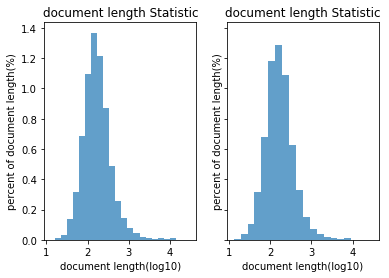

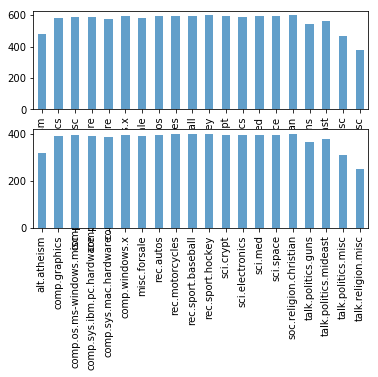

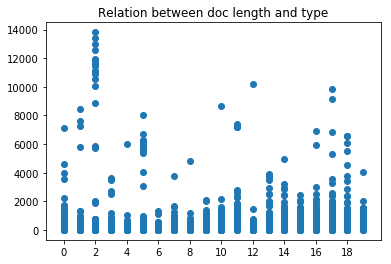

In [12]:
#分析新闻20
def ana_news20():
    document_train_x, document_train_y, document_test_x, document_test_y = get_x_y()
    document_train_x_refined, document_test_x_refined = get_x_y_refined()
    #Length of documents
    document_train_x_len = [len(doc) for doc in document_train_x_refined]
    document_test_x_len = [len(doc) for doc in document_test_x_refined]
    document_train_y_type = {}
    document_test_y_type = {}
    for doc in document_train_y:
        if doc not in document_train_y_type:
            document_train_y_type[doc] = 1
        else:
            document_train_y_type[doc] += 1
    for doc in document_test_y:
        if doc not in document_test_y_type:
            document_test_y_type[doc] = 1
        else:
            document_test_y_type[doc] += 1
    
    #组合len, type
    from sklearn import preprocessing
    le = preprocessing.LabelEncoder()
    le.fit(document_train_y)
    document_train_y_digital = le.transform(document_train_y)
    document_test_y_digital = le.transform(document_test_y)
    document_train_len_type = list(zip(document_train_x_len, 
                                       document_train_y_digital))
    document_test_len_type = list(zip(document_test_x_len, 
                                      document_test_y_digital))
    print(document_train_len_type[:30])
    
    #文档长度
    print(document_train_x_len[:10])
    fig, axe = plt.subplots(1,2, sharex=True, sharey=True)
    for i in range(2):
        axe[i].set_title("document length Statistic")
        axe[i].set_xlabel("document length(log10)")
        axe[i].set_ylabel("percent of document length(%)")
    axe[0].hist(np.log10(Series(document_train_x_len)), 
                normed = True, bins = 20, alpha = 0.7)
    axe[1].hist(np.log10(Series(document_test_x_len)), 
                normed = True, bins = 20, alpha = 0.7)

    fig1, axe1 = plt.subplots(2,1, sharex=True, sharey=True)
    print(Series(document_train_y_type))
    print(Series(document_test_y_type))
    axe1[0].set_title("document type Statistic")
    axe1[0].set_xlabel("document type(log10)")
    axe1[0].set_ylabel("percent of document length(%)")
    plt.subplot(211)
    Series(document_train_y_type).plot(alpha = 0.7, kind ="bar")
    plt.subplot(212)
    Series(document_test_y_type).plot(alpha = 0.7, kind = "bar")
    
    #文档类型与长度的关系探索
    fig2, axe2 = plt.subplots(1,1)
    axe2.set_xticks(range(0,20,2))
    axe2.set_title("Relation between doc length and type")
    axe2.scatter([b[1] for b in document_train_len_type],
                 [a[0]for a in document_train_len_type])
#开始测试
ana_news20()

In [13]:
#保存训练测试
file_train_x = "preprocessor_train_x.p"
file_test_x = "preprocessor_test_x.p"

In [14]:
import pickle
document_train_x_refined, document_test_x_refined = get_x_y_refined()
pickle.dump((document_train_x_refined, document_train_y), 
            open(file_train_x, 'wb'))
pickle.dump((document_test_x_refined, document_test_y), 
            open(file_test_x, 'wb'))
#del document_train_x_refined, document_train_y 
#del document_test_x_refined, document_test_y          

## 重启节点, 这里我们可以重新开始训练，不用重复数据预处理

In [15]:
#定义不同的文档模型开关 
DOC_MODEL_TFIDF = True
DOC_MODEL_WORD2VEC100_AVERAGE = True #
DOC_MODEL_WORD2VEC300_AVERAGE = True #
DOC_MODEL_WORD2VEC1000_AVERAGE = True #
DOC_MODEL_WORD2VEC100_AVERAGE_TFIDF = True #
DOC_MODEL_WORD2VEC300_AVERAGE_TFIDF = True #
DOC_MODEL_WORD2VEC100_EXTEND_TFIDF = False #
DOC_MODEL_WORD2VEC300_EXTEND_TFIDF = False #
DOC_MODEL_WORD2VEC = (DOC_MODEL_WORD2VEC100_AVERAGE or 
                     DOC_MODEL_WORD2VEC300_AVERAGE or 
                     DOC_MODEL_WORD2VEC100_AVERAGE_TFIDF or 
                     DOC_MODEL_WORD2VEC300_AVERAGE_TFIDF)
DOC_MODEL_DOC2VEC100 = True
DOC_MODEL_DOC2VEC300 = True #0 = False #
DOC_MODEL_DOC2VEC = DOC_MODEL_DOC2VEC100 or DOC_MODEL_DOC2VEC300
DOC_MODEL_GLOVE100 = False # 本项目暂不支持
DOC_MODEL_GLOVE300 = False # 本项目暂不支持
DOC_MODEL_GLOVE = DOC_MODEL_GLOVE100 or DOC_MODEL_GLOVE300
#定义使用机器学习模型
ML_SVM = True
ML_NB = True
ML_TF_FULL = True
ML_TF_RNN = True

#定义是否刷新所有数据
RENEW_ALL = True


In [16]:
#加载预处理训练、测试数据
import pickle
document_train_x_refined, document_train_y = pickle.load(
    open('preprocessor_train_x.p', mode='rb'))
document_train_y_lb = lb.transform(document_train_y)
document_train_y_le = le.transform(document_train_y)
document_test_x_refined, document_test_y = pickle.load(
    open('preprocessor_test_x.p', mode='rb'))
document_test_y_lb = lb.transform(document_test_y)
document_train_y_le = le.transform(document_train_y)

训练数据被进一步随机打乱次序并按8:2分拆成训练和测试，使用sklearn.model_selection.train_test_split
document_train_x_train
document_train_x_test
document_train_y_train
document_train_y_test

In [17]:
from sklearn.model_selection import train_test_split
document_train_x_train, document_train_x_test, document_train_y_train, \
document_train_y_test = train_test_split (
    document_train_x_refined, document_train_y, test_size = 0.2)
document_train_y_train_lb = lb.transform(document_train_y_train)
document_train_y_test_lb = lb.transform(document_train_y_test)
document_train_y_train_le = le.transform(document_train_y_train)
document_train_y_test_le = le.transform(document_train_y_test)
#训练集采用全集，在每个模型训练时再动态拆分
#document_train_x_train = document_train_x_refined
#document_train_y_train = document_train_y
#document_train_y_train_lb = lb.transform(document_train_y_train)
#document_train_y_test_lb = lb.transform(document_train_y_test)
print (document_train_y_train_lb[:10])
#释放原始内存
#del document_train_x_refined, document_train_y_lb

[[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]]


## 执行过程


### 1. 词向量的准备

生成word2vec模型，本项目采用gensim.models.Word2Vec库，基于text8生成词向量模型
* model_word2vec

In [18]:
#预处理删除辅助词与低频词
#直接使用text8接口读取词库
import numpy
import warnings
import pandas
from gensim import corpora, models, similarities
from gensim.models.word2vec import Word2Vec
from os import mkdir

#词向量最大单词量
max_vocab_size = 20000

def make_word2vec_model(size):
    model_file = model_path + "/word2vec" + str(size) + ".md"
    if isfile(model_file) and (RENEW_ALL == False):
        print("loading word2vec 100 model")
        model = Word2Vec.load(model_file)
    else:
        sentences = models.word2vec.Text8Corpus(text8_path + '/text8', 
                                                max_sentence_length=10000)
        #print (sentences)
        model = Word2Vec(sentences, size=size, window=5, max_vocab_size = max_vocab_size,
                         min_count=5, workers=4)
        #检查并创建模型目录
        assert isdir(model_path), mkdir(model_path)
        #保存模型
        model.save(model_file)
    return model

#基于news20创建word2vec模型
def make_word2vec_model_news20(size):
    model_file = model_path + "/word2vecnews" + str(size) + ".md"
    if isfile(model_file) and (RENEW_ALL == False):
        model = Word2Vec.load(model_file)
    else:
        #print (sentences)
        document_train_x_phrases, _ = get_x_y_phrases()
        model = Word2Vec(document_train_x_phrases, size=size, window=5, max_vocab_size = max_vocab_size,
                         min_count=5, workers=4)
        #检查并创建模型目录
        assert isdir(model_path), mkdir(model_path)
        #保存模型
        model.save(model_file)
    return model


if DOC_MODEL_WORD2VEC100_AVERAGE == True:
    model = make_word2vec_model_news20(100)
    #使用模型实例100纬度，不再训练模型
    model_word2vec100 = model.wv
    result = model.wv.evaluate_word_pairs('test_data'+'/wordsim353.tsv')
    print (result)
    result = model.wv.accuracy('test_data'+'/questions-words.txt')
    print (result)
    del model
    #测试
if DOC_MODEL_WORD2VEC300_AVERAGE == True:
    model = make_word2vec_model_news20(300)
    #使用模型实例300纬度，不再训练模型
    model_word2vec300 = model.wv
    result = model.wv.evaluate_word_pairs('test_data'+'/wordsim353.tsv')
    print (result)
    result = model.wv.accuracy('test_data'+'/questions-words.txt')
    print (result)
    del model


((0.20854103927564555, 0.0092144461420979196), SpearmanrResult(correlation=0.20135046846721705, pvalue=0.011995159161682091), 56.09065155807366)
[{'section': 'capital-common-countries', 'correct': [], 'incorrect': [('MOSCOW', 'RUSSIA', 'OTTAWA', 'CANADA'), ('OTTAWA', 'CANADA', 'MOSCOW', 'RUSSIA')]}, {'section': 'capital-world', 'correct': [], 'incorrect': [('ANKARA', 'TURKEY', 'BAKU', 'AZERBAIJAN'), ('MOSCOW', 'RUSSIA', 'OTTAWA', 'CANADA'), ('OTTAWA', 'CANADA', 'ANKARA', 'TURKEY')]}, {'section': 'currency', 'correct': [], 'incorrect': []}, {'section': 'city-in-state', 'correct': [], 'incorrect': [('CHICAGO', 'ILLINOIS', 'HOUSTON', 'TEXAS'), ('CHICAGO', 'ILLINOIS', 'DALLAS', 'TEXAS'), ('CHICAGO', 'ILLINOIS', 'DETROIT', 'MICHIGAN'), ('CHICAGO', 'ILLINOIS', 'SEATTLE', 'WASHINGTON'), ('CHICAGO', 'ILLINOIS', 'MIAMI', 'FLORIDA'), ('CHICAGO', 'ILLINOIS', 'OAKLAND', 'CALIFORNIA'), ('HOUSTON', 'TEXAS', 'DETROIT', 'MICHIGAN'), ('HOUSTON', 'TEXAS', 'SEATTLE', 'WASHINGTON'), ('HOUSTON', 'TEXAS', '

In [19]:
if DOC_MODEL_WORD2VEC1000_AVERAGE == True:
    model = make_word2vec_model(1000)
    model_word2vec1000 = model.wv
    result = model.wv.evaluate_word_pairs('test_data'+'/wordsim353.tsv')
    print (result)
    result = model.wv.accuracy('test_data'+'/questions-words.txt')
    print (result)
    del model

((0.64946815299793526, 5.0647301591190338e-30), SpearmanrResult(correlation=0.66228320511425953, pvalue=1.5059237051869646e-31), 32.29461756373937)
[{'section': 'capital-common-countries', 'correct': [('ATHENS', 'GREECE', 'BERLIN', 'GERMANY'), ('ATHENS', 'GREECE', 'CANBERRA', 'AUSTRALIA'), ('ATHENS', 'GREECE', 'MOSCOW', 'RUSSIA'), ('ATHENS', 'GREECE', 'ROME', 'ITALY'), ('BAGHDAD', 'IRAQ', 'BERLIN', 'GERMANY'), ('BAGHDAD', 'IRAQ', 'CANBERRA', 'AUSTRALIA'), ('BAGHDAD', 'IRAQ', 'PARIS', 'FRANCE'), ('BAGHDAD', 'IRAQ', 'ATHENS', 'GREECE'), ('BEIJING', 'CHINA', 'BERLIN', 'GERMANY'), ('BEIJING', 'CHINA', 'CAIRO', 'EGYPT'), ('BEIJING', 'CHINA', 'CANBERRA', 'AUSTRALIA'), ('BEIJING', 'CHINA', 'LONDON', 'ENGLAND'), ('BEIJING', 'CHINA', 'MADRID', 'SPAIN'), ('BEIJING', 'CHINA', 'PARIS', 'FRANCE'), ('BEIJING', 'CHINA', 'TOKYO', 'JAPAN'), ('BERLIN', 'GERMANY', 'CANBERRA', 'AUSTRALIA'), ('BERLIN', 'GERMANY', 'HELSINKI', 'FINLAND'), ('BERLIN', 'GERMANY', 'LONDON', 'ENGLAND'), ('BERLIN', 'GERMANY', 'MAD

In [20]:
#以word2vec100为例，检查一下模型性
if DOC_MODEL_WORD2VEC100_AVERAGE == True:
    #检查相似性
    def model_test():
        try:
            print (model_word2vec100["computer"])
            print(model_word2vec100.most_similar(
                positive=['woman', 'king'], negative=['man']))
            print(model_word2vec100.most_similar_cosmul(
                positive=['woman', 'king'], negative=['man']))
            print(model_word2vec100.doesnt_match("breakfast cereal dinner lunch".split()))
            print("The similarity of 'woman' and 'man' is:", 
                  model_word2vec100.similarity('woman', 'man'))
            print("The similarity of 'computer' and 'pc' is:",
                  model_word2vec100.similarity('computer', 'pc'))
            print("The similarity of 'computer' and 'hp' is:",
                  model_word2vec100.similarity('computer', 'hp'))
        except:
            pass
    model_test()

[-0.34451538  0.17821327  0.01022334 -0.11916613  0.09274076 -0.15946025
  0.77698296 -0.40253514  0.05588655  0.25308108  0.81237382  0.04381099
 -0.07088231  0.50202906  0.32545644 -0.5518595   1.00738919 -0.24374202
  0.0781564  -0.34993491 -0.90136147 -0.33785284 -0.16088797 -0.12734939
  0.94700634  0.59878063  0.18570144 -0.25067851  0.58620703 -0.02374094
 -0.48778471 -0.48468828 -0.34695584 -0.35009795 -0.32047239 -0.24767675
 -0.31603932  0.3100515  -0.28604868 -0.43782875 -0.46721566 -0.26544601
  0.06746547 -0.21104425 -0.30464044 -0.23431824 -0.27608451  0.73639572
 -0.41781923 -0.39802146 -0.74869895  1.09585238  0.11556005 -0.06050423
 -0.65075481  1.03733146  0.11876073  0.19718903 -0.26356182  0.10665151
 -0.23621017  0.19354811 -0.34473148  0.27712691  0.19742946 -0.09022666
 -0.33727351  0.30415809  0.91345519 -1.02813542  0.68192577  0.66813201
 -0.55894291 -0.17263049  0.43193904 -0.49385092 -0.40931907 -0.45269093
  0.3521654   0.24582067 -0.22635217 -0.18944089  0

### 2. 生成TFIDF语料库
* Step1 - 基于News20, 使用gensim.corpora.Dictionary生成词典
* Step 2 - 文档创建词袋子，使用Dictionary.doc2bow()
      *corpus_bow_train_x
      *corpus_bow_test_x
* step 3 - 生成TFIDF文档库

In [21]:
#step 1保存字典
from gensim.models import TfidfModel
from gensim import corpora
def make_dictionary():
    document_train_x_refined, document_train_y_refined = pickle.load(
        open(file_train_x, mode = "rb"))
    document_test_x_refined, document_test_y_refined = pickle.load(
        open(file_test_x, mode = "rb"))
    #step - 1 创建词典
    assert isdir (temp_path), os.mkdir(temp_path)
    if isfile(temp_path + '/20news.dict') and (RENEW_ALL == False):
        print("loading dictionary")
        dictionary = corpora.Dictionary.load(temp_path + '/20news.dict')
    else:
        dictionary = corpora.Dictionary(document_train_x_refined)
        dictionary.save(temp_path + '/20news.dict')  # store the dictionary, for future reference
    return dictionary
dictionary = make_dictionary()
print("字典共有单词{}个".format(len(dictionary)))    

字典共有单词107010个


In [22]:
#step 2 生成词袋子文档库, 由于每次培训和测试的文档是不同的，这里不用文档序列化
def get_bow_x_y():
    #assert isdir(model_path), os.mkdir(model_path)
    #if not isfile(model_path + '/corpus_bow_train.mm') or not isfile(model_path + '/corpus_bow_test.mm'):
    corpus_bow_train_x = [
        dictionary.doc2bow(text) for text in document_train_x_refined]
    corpus_bow_train_x_train = [
        dictionary.doc2bow(text) for text in document_train_x_train]
    corpus_bow_train_x_test = [
        dictionary.doc2bow(text) for text in document_train_x_test]
    corpus_bow_test_x = [
        dictionary.doc2bow(text) for text in document_test_x_refined]
    return corpus_bow_train_x, corpus_bow_train_x_train, corpus_bow_train_x_test, corpus_bow_test_x
    
#测试
corpus_bow_train_x, corpus_bow_train_x_train, corpus_bow_train_x_test, corpus_bow_test_x = get_bow_x_y()
print(corpus_bow_train_x_train[0][:10])
print(corpus_bow_train_x_test[0][:10])
print(corpus_bow_test_x[0][:10])

#del document_train_x_refined #, document_test_x_refined

[(0, 3), (5, 1), (26, 1), (30, 1), (49, 1), (63, 2), (65, 4), (71, 1), (83, 3), (95, 2)]
[(0, 62), (5, 1), (11, 1), (15, 17), (25, 2), (26, 8), (28, 1), (30, 1), (32, 13), (33, 2)]
[(0, 1), (5, 1), (24, 1), (26, 1), (30, 1), (49, 1), (63, 1), (65, 3), (71, 2), (74, 2)]


Step 3: 生成tfidf 文档库
* corpus_tfidf_train tfidf训练集
* corpus_tfidf_test  tfidf测试集

In [23]:
if DOC_MODEL_TFIDF == True:
    #step 3 - create TFIDF 模型 
    if isfile(model_path + '/news20.tfidf_model') and (RENEW_ALL == False):
        tfidf = TfidfModel.load(model_path + '/news20.tfidf_model')
    else:
        tfidf = TfidfModel(corpus_bow_train_x_train)
        #model_test()
        tfidf.save(model_path + '/news20.tfidf_model')
    #测试
    print(tfidf[corpus_bow_train_x_test[0]])

[(11, 0.0028163700831898304), (15, 0.0355705077795796), (25, 0.0032586080047111473), (26, 0.00028569565556015443), (28, 0.0037284124536492765), (30, 2.822143498718e-06), (32, 0.03131335405203924), (33, 0.003976886303572844), (37, 0.004189683429138944), (47, 0.013791668427283197), (49, 0.021237801635566097), (51, 0.07037313648003787), (54, 0.007260369255861046), (55, 0.009372572351518308), (56, 0.0028410801236863257), (59, 0.00401696801173114), (63, 0.04002464162438009), (64, 0.044820016773144934), (65, 0.015560303491454012), (67, 0.02910666778568224), (68, 0.018317454091954448), (71, 0.040284916146864524), (72, 0.03471084644888408), (73, 0.003436706486754418), (74, 0.033697826481492756), (75, 0.026811381701222676), (76, 0.004094717696010552), (77, 0.0028097457188238665), (79, 0.0034279901897555933), (83, 0.012066989752644534), (90, 0.09477808574336329), (95, 0.022298024367589594), (96, 0.024075303862188747), (98, 0.02706167865824331), (105, 0.05671369235971253), (106, 0.060310377107911

In [24]:
if DOC_MODEL_TFIDF == True:
    corpus_tfidf_train = [tfidf[x] for x in corpus_bow_train_x]
    corpus_tfidf_train_train = [tfidf[x] for x in corpus_bow_train_x_train]
    corpus_tfidf_train_test = [tfidf[x] for x in corpus_bow_train_x_test]
    corpus_tfidf_test  = [tfidf[x] for x in corpus_bow_test_x]

In [25]:
print(corpus_tfidf_train_train[0])

[(26, 0.0008886039709188019), (30, 7.022208061362627e-05), (49, 0.014679175393400239), (63, 0.014645801362330579), (65, 0.011644504525111076), (71, 0.01113767535784752), (83, 0.0187660799220286), (95, 0.035795570450588655), (96, 0.029952727942008508), (125, 0.06538201692900164), (153, 0.03986241662599926), (161, 0.06095091014444901), (166, 0.012735867005880173), (257, 0.023214960198338474), (275, 0.011542403227013057), (305, 0.037101078133949986), (323, 0.03937345008141561), (331, 0.06496590786057892), (336, 0.03542699972241225), (418, 0.08236533594596301), (462, 0.04438461910829209), (488, 0.048436666106386216), (495, 0.02982010333780056), (496, 0.04872206111322034), (501, 0.057913126408423055), (537, 0.02107199187337806), (607, 0.04961121590151054), (649, 0.06157941977851205), (743, 0.07596411134928348), (773, 0.033557795374851845), (774, 0.020958069586331066), (782, 0.07519099532915388), (788, 0.024936714827846408), (805, 0.011946004915625665), (818, 0.043418021726308445), (822, 0.0

In [26]:
if DOC_MODEL_TFIDF == True:
    #TFIDF相似性检测
    nb_feature = len(dictionary)
    from gensim.similarities.docsim import Similarity
    index_tfidf = Similarity('temp/similty_idx', 
                             corpus_tfidf_train_train, 
                             num_features=nb_feature) 

In [27]:
if DOC_MODEL_TFIDF == True:
    index_tfidf.num_best = 10
    print (index_tfidf[corpus_tfidf_train_train[0]])


[(0, 1.0000001192092896), (1447, 0.22341457009315491), (2850, 0.13363564014434814), (3141, 0.12201014161109924), (597, 0.11486833542585373), (4043, 0.11166173219680786), (8773, 0.10807515680789948), (1, 0.10474877804517746), (7686, 0.1042332798242569), (8409, 0.099842816591262817)]


In [28]:
#另一种方法，直接通过sklearn读取20newsgroups
#由于这个接口专为20newsgroups设计，虽然简单，不具有通用性，这里不采用
#from sklearn.datasets import fetch_20newsgroups
#newsgroups_train = fetch_20newsgroups(subset='train')
#from pprint import pprint
#pprint(list(newsgroups_train.target_names))
#print (newsgroups_train.filenames[:10])
#print (newsgroups_train.data[:2])

In [29]:
corpus_bow_train_x_test[0]

[(0, 62),
 (5, 1),
 (11, 1),
 (15, 17),
 (25, 2),
 (26, 8),
 (28, 1),
 (30, 1),
 (32, 13),
 (33, 2),
 (37, 1),
 (47, 11),
 (49, 36),
 (51, 41),
 (54, 3),
 (55, 4),
 (56, 1),
 (59, 1),
 (63, 136),
 (64, 90),
 (65, 133),
 (67, 28),
 (68, 6),
 (71, 90),
 (72, 25),
 (73, 1),
 (74, 56),
 (75, 51),
 (76, 1),
 (77, 1),
 (79, 1),
 (83, 48),
 (90, 70),
 (95, 31),
 (96, 20),
 (98, 6),
 (105, 49),
 (106, 34),
 (114, 2),
 (120, 45),
 (121, 63),
 (122, 8),
 (125, 27),
 (128, 1),
 (134, 2),
 (144, 55),
 (146, 2),
 (149, 1),
 (153, 21),
 (157, 3),
 (161, 22),
 (164, 5),
 (166, 23),
 (168, 2),
 (171, 1),
 (176, 1),
 (179, 1),
 (181, 289),
 (205, 10),
 (211, 3),
 (213, 1),
 (231, 5),
 (244, 1),
 (248, 19),
 (253, 4),
 (254, 4),
 (257, 220),
 (259, 70),
 (261, 2),
 (263, 14),
 (265, 2),
 (266, 6),
 (269, 20),
 (275, 20),
 (282, 5),
 (288, 1),
 (290, 3),
 (291, 1),
 (296, 2),
 (302, 8),
 (312, 2),
 (313, 9),
 (315, 14),
 (319, 31),
 (321, 81),
 (322, 3),
 (323, 14),
 (325, 103),
 (328, 24),
 (330, 1),
 (

### 3. 文档向量的表达

#### 3.1 基于词向量平均值生成文档向量
如果一个单词的含义可以用100/300维度的向量来近似表示，那文档的总体含义必然可以通过单词的平均来大致表达。
* document_train_x_train_average_word_vec
* document_train_x_test_average_word_vec
* document_test_x_average_word_vec

In [30]:
import numpy as np
from numpy import array

def average_word_vec(doc, size):
    nb_word = 0
    word_vec_model = globals()["model_word2vec" + str(size)]
    sum_vec = np.zeros(len(word_vec_model['test'])) #初始化阵列，大小为model.wv
    for word in doc:
        try:
            word_vec = word_vec_model[word]
            nb_word += 1
            sum_vec = sum_vec + word_vec
        except: pass #model.wv[word] has errors when the word is not in dictionary
    return sum_vec/nb_word

if DOC_MODEL_WORD2VEC100_AVERAGE == True:

    #测试
    print(average_word_vec(['machine', 'learning'], 100))
    #生成词向量文档库
    document_train_x_train_average_word_vec100 = [
        average_word_vec(x, 100) for x in document_train_x_train]
    print (document_train_x_train_average_word_vec100[:1])
    document_train_x_test_average_word_vec100 = [
        average_word_vec(x, 100) for x in document_train_x_test]
    print (document_train_x_test_average_word_vec100[:1])
    document_test_x_average_word_vec100 = [
        average_word_vec(x, 100) for x in document_test_x_refined]
    print (document_test_x_average_word_vec100[:1])

if DOC_MODEL_WORD2VEC300_AVERAGE == True:
    print(average_word_vec(['machine', 'learning'], 300))
    #生成词向量文档库
    document_train_x_train_average_word_vec300 = [
        average_word_vec(x, 300) for x in document_train_x_train]
    print (document_train_x_train_average_word_vec300[:1])
    document_train_x_test_average_word_vec300 = [
        average_word_vec(x, 300) for x in document_train_x_test]
    print (document_train_x_test_average_word_vec300[:1])
    document_test_x_average_word_vec300 = [
        average_word_vec(x, 300) for x in document_test_x_refined]
    print (document_test_x_average_word_vec300[:1])

if DOC_MODEL_WORD2VEC1000_AVERAGE == True:
    print(average_word_vec(['machine', 'learning'], 1000))
    #生成词向量文档库
    document_train_x_train_average_word_vec1000 = [
        average_word_vec(x, 1000)for x in document_train_x_train]
    print (document_train_x_train_average_word_vec1000[:1])
    document_train_x_test_average_word_vec1000 = [
        average_word_vec(x, 1000) for x in document_train_x_test]
    print (document_train_x_test_average_word_vec1000[:1])
    document_test_x_average_word_vec1000 = [
        average_word_vec(x, 1000)for x in document_test_x_refined]
    print (document_test_x_average_word_vec1000[:1])
    

[ -2.93291435e-01   3.44479851e-01   1.76627684e-01  -3.66769731e-01
  -1.56270899e-01  -1.18888564e-01   1.86700743e-01   1.19478881e-01
   8.74242093e-02  -1.76215120e-01   5.56063876e-02   1.27693454e-01
  -5.42866990e-01  -1.64603628e-01   2.94050984e-01  -2.85889804e-02
   4.44218822e-01  -2.99608957e-01   2.68350955e-01  -2.93264262e-01
  -5.55536042e-01   1.00593556e-01   1.47715211e-04  -9.82185416e-02
   2.68231690e-01   3.74276124e-01  -6.53365329e-02  -1.69743903e-01
   2.94694474e-01   5.17981257e-02  -3.08496594e-01  -2.11012140e-01
  -6.13910943e-01  -4.20294851e-02  -8.30763660e-01  -3.96136336e-01
   1.77564034e-01   1.11371942e-01  -5.69739312e-01  -2.13591702e-01
  -2.33381573e-01   1.55545160e-01   2.62426072e-01   2.69855924e-01
  -3.80278200e-01   2.97426995e-01  -1.78510951e-01   2.73311809e-01
  -2.60130972e-01  -5.36735475e-01  -3.08424130e-01   9.45964232e-01
  -1.04868047e-01   4.63559411e-01  -5.75593390e-01   7.93054789e-01
  -3.69708642e-01  -3.79616022e-03

#### 3.2 生成基于TFIDF 的词向量文档库
在3.1中取得的是所有单词的词向量，这里尝试每个单词的词向量乘以其TFIDF值，以期体现每个单词表达含义的重要性。
* document_train_x_average_word_vec_tfidf
* document_test_x_average_word_vec_tfidf

In [31]:
#基于skip-gram的IDF平均值创建文档20newgroups的文档向量
def getwordfromid(word_id):
    return dictionary.get(word_id)

#生成反向查询字典，从ID到单词
dictionary_reverse = {}
for key, value in dictionary.items():
    dictionary_reverse[value] = key
    
def getidfromword(word):
    return dictionary_reverse.get(word)

def tfidf_word2vec(tfidf_doc, size):
    nb_word = 0
    word_vec_model = globals()["model_word2vec" + str(size)]
    #初始化阵列，大小为model.wv
    sum_vec = np.zeros(len(word_vec_model['test']))     
    for word_tfidf in tfidf_doc:
        word = getwordfromid(word_tfidf[0])
        if None == word:
            continue
        try:
            #字矢量*字tfidf权重           
            word_vec_tfidf = word_vec_model[word] * word_tfidf[1]
            nb_word += 1
            sum_vec = sum_vec + word_vec_tfidf
        except: continue #model.wv[word] has errors when the word is not in dictionary
    return sum_vec/nb_word

In [32]:

if DOC_MODEL_WORD2VEC100_AVERAGE_TFIDF == True:
    document_train_x_train_average_word_vec100_tfidf = [
        tfidf_word2vec(x, 100)for x in corpus_tfidf_train_train]
    #print (document_train_x_train_average_word_vec_tfidf[:1])
    document_train_x_test_average_word_vec100_tfidf = [
        tfidf_word2vec(x, 100) for x in corpus_tfidf_train_test]
    #print (document_train_x_test_average_word_vec_tfidf[:1])
    document_test_x_average_word_vec100_tfidf = [
        tfidf_word2vec(x, 100) for x in corpus_tfidf_test]
    #print (document_test_x_average_word_vec_tfidf[:1])
    
if DOC_MODEL_WORD2VEC300_AVERAGE_TFIDF == True:
    document_train_x_train_average_word_vec300_tfidf = [
        tfidf_word2vec(x, 300) for x in corpus_tfidf_train_train]
    #print (document_train_x_train_average_word_vec_tfidf[:1])
    document_train_x_test_average_word_vec300_tfidf = [
        tfidf_word2vec(x, 300) for x in corpus_tfidf_train_test]
    #print (document_train_x_test_average_word_vec_tfidf[:1])
    document_test_x_average_word_vec300_tfidf = [
        tfidf_word2vec(x, 300) for x in corpus_tfidf_test]
    #print (document_test_x_average_word_vec_tfidf[:1])


#### 3.3 生成doc2vec 文档库
* Step 1 文档标记

In [33]:
#step 1, 文档标记
import gensim
from gensim.models.doc2vec import Doc2Vec

if DOC_MODEL_DOC2VEC == True:
    def tag_document(documents):
        doc_nb = 0
        for x in documents:
            yield gensim.models.doc2vec.TaggedDocument(x,[doc_nb])
            doc_nb +=1

    corpus_train_train_doc2vec = list(tag_document(document_train_x_train))
    corpus_train_test_doc2vec = list(tag_document(document_train_x_test))
    corpus_test_doc2vec = list(tag_document(document_test_x_refined))
    print(corpus_train_train_doc2vec[:1])


[TaggedDocument(words=['from', 'apd2c', 'virginia', 'edu', 'andrew', 'paul', 'dickens', 'subject', 're', 'computer', 'graphics', 'vcr', 'organization', 'university', 'virginia', 'lines', 'getting', 'an', 'image', 'from', 'a', 'computer', 'monitor', 'a', 'videotape', 'is', 'harder', 'than', 'it', 'looks', 'standard', 'vga', 'ega', 'outputs', 'are', 'very', 'different', 'than', 'ntsc', 'format', 'used', 'by', 'televisions', 'while', 'there', 'is', 'equipment', 'that', 'will', 'do', 'conversion', 'it', 'is', 'hard', 'get', 'your', 'hands', 'on', 'costs', 'quite', 'a', 'bit', 'if', 'you', 'have', 'access', 'an', 'amiga', 'computer', 'that', 'has', 'an', 'ntsc', 'output', 'you', 'can', 'transfer', 'certain', 'types', 'graphic', 'files', 'by', 'modem', 'tape', 'them', 'from', 'ntsc', 'output', 'unfortunately', 'this', 'would', 'be', 'frame', 'by', 'frame', 'would', 'lead', 'unbelievably', 'scratchy', 'animation', 'unless', 'you', 'had', 'a', 'good', 'amiga', 'animation', 'program', 'otherwis

In [34]:
#Step 2, 使用gensim.models.doc2vec.Doc2Vec生成doc2vec模型
if DOC_MODEL_DOC2VEC100 == True:
    if not isfile(model_path + '/doc2vec100.model') and (RENEW_ALL == False):
        model_doc2vec100 = Doc2Vec.load(model_path + '/doc2vec100.model')
    else:
        #instantiate the model with 100 dimention
        model_doc2vec100 = gensim.models.doc2vec.Doc2Vec(
            size=100, min_count=2, iter=55)
        #build a vacabulary
        model_doc2vec100.build_vocab(corpus_train_train_doc2vec)
        #Time for train
        %time model_doc2vec100.train(corpus_train_train_doc2vec, \
                                     total_examples=model_doc2vec100.corpus_count, \
                                     epochs=model_doc2vec100.iter)
        model_doc2vec100.save(model_path + "/doc2vec100.model")

if DOC_MODEL_DOC2VEC300 == True:
    if not isfile(model_path + '/doc2vec300.model') and (RENEW_ALL == False):
        model_doc2vec300 = Doc2Vec.load(model_path + '/doc2vec300.model')
    else:
        #instantiate the model with 300 dimention
        model_doc2vec300 = gensim.models.doc2vec.Doc2Vec(
            size=300, min_count=2, iter=55)
        #build a vacabulary
        model_doc2vec300.build_vocab(corpus_train_train_doc2vec)
        #Time for train
        %time model_doc2vec300.train(corpus_train_train_doc2vec, \
                                      total_examples=model_doc2vec300.corpus_count, \
                                      epochs=model_doc2vec300.iter)
        model_doc2vec100.save(model_path + "/doc2vec300.model")


Wall time: 3min 33s
Wall time: 5min 44s


In [35]:
if DOC_MODEL_DOC2VEC100 == True:
    #打印第一份文档向量
    model_doc2vec100.infer_vector(corpus_train_train_doc2vec[0].words)
if DOC_MODEL_DOC2VEC300 == True:
    #打印第一份文档向量
    model_doc2vec300.infer_vector(corpus_train_train_doc2vec[0].words)

In [36]:
#Step 3生成文档向量
if DOC_MODEL_DOC2VEC100 == True:
    document_train_x_train_doc2vec100 = [model_doc2vec100.infer_vector
                                         (x.words) for x in 
                                         corpus_train_train_doc2vec]
    document_train_x_test_doc2vec100 = [model_doc2vec100.infer_vector
                                        (x.words) for x in 
                                        corpus_train_test_doc2vec]
    document_test_x_doc2vec100 = [model_doc2vec100.infer_vector(x.words) 
                                  for x in corpus_test_doc2vec]
if DOC_MODEL_DOC2VEC300 == True:
    document_train_x_train_doc2vec300 = [model_doc2vec300.infer_vector
                                         (x.words) for x in 
                                         corpus_train_train_doc2vec]
    document_train_x_test_doc2vec300 = [model_doc2vec300.infer_vector
                                        (x.words) for x in 
                                        corpus_train_test_doc2vec]
    document_test_x_doc2vec300 = [model_doc2vec300.infer_vector(x.words) 
                                  for x in corpus_test_doc2vec]    

In [37]:
#获取wordvec100词向量映射表
def get_embedding_matrix_word100(word_index, nb_words, emedding_dim):
    embedding_matrix = np.zeros((nb_words + 1, embedding_dim))

    for word, i in word_index.items():
        if i > max_nb_token:
            continue
        try:
            embedding_vector = model_word2vec100[word]
        except:
            continue
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector # word_index to word_embedding_vector ,<20000(nb_words)
    return embedding_matrix

#获取静态Glove 50维词向量
glove_dir = "glove_vector/"
def get_embedding_matrix_glove50(word_index, nb_words, embedding_dim, index_reverse = False):
    #读取Globe完整词向量
    embeddings_index = {}
    f = open(os.path.join(glove_dir, 'glove.6B.50d.txt'),encoding='UTF-8') # 读入50维的词向量文件，可以改成100维或者其他
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()
    #取所需的单词词向量
    embedding_matrix = np.zeros((nb_words + 1, embedding_dim))
    #If True, (id, word)用在字典中, else (word, id)用在Token中
    if index_reverse == True:
        for i, word in word_index.items():
            if i > nb_words:
                continue
            try:
                embedding_vector = embeddings_index.get(word)
            except:
                continue
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector # word_index to word_embedding_vector ,<20000(nb_words) 
    else:
        for word, i in word_index.items():
            if i > nb_words:
                continue
            try:
                embedding_vector = embeddings_index.get(word)
            except:
                continue
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector # word_index to word_embedding_vector ,<20000(nb_words) 
            
    return embedding_matrix


### 4. 这里分别使用SVM, 朴素贝叶斯和神经网络学习文档分类

#### 4.1 定义评估函数

In [38]:
import numpy as np
def accuracy_score(truth, pred):
    """ Returns accuracy score for input truth and predictions. """
    # 确保预测的数量与结果的数量一致
    if len(truth) == len(pred): 
        # 计算预测准确率（百分比）
        return "Predictions have an accuracy of {:.2f}%.".format(
            (truth == pred).mean()*100) 
    else:
        return "Number of predictions does not match number of outcomes!"  
# 测试 'accuracy_score' 函数
outcomes = np.array([0, 1,2,3,4])
predictions = np.array([1,1,1,1,1])
print (accuracy_score(outcomes, predictions))

Predictions have an accuracy of 20.00%.


In [39]:
from sklearn.metrics import f1_score
scoring = ['f1_macro', 'f1_micro']
#输入模型预测后再比较
def get_f1_score(clf, input_data, target_data):
    predict_data = clf.predict(input_data)
    f1_macro = f1_score(target_data, predict_data,  average = 'macro')
    f1_micro = f1_score(target_data, predict_data,  average = 'micro')
    return f1_macro, f1_micro

#直接比较输入输出
def get_f1_score_pure(input_data, target_data):
    f1_macro = f1_score(target_data, input_data,  average = 'macro')
    f1_micro = f1_score(target_data, input_data,  average = 'micro')
    return f1_macro, f1_micro



 _gensim生成的稀疏矩阵格式[(1, "a word"),(2, "b word"),(3, "c word)]与Sklearn要求的稀疏矩阵格式不符，需要转换。本方法参考[博客](http://blog.csdn.net/u014595019/article/details/52433754)_

In [40]:
from scipy.sparse import csr_matrix
def sparse_gensim2matrix(corpus):
    data = []
    rows = []
    cols = []
    line_count = 0
    for doc in corpus:  # lsi_corpus_total 是之前由gensim生成的lsi向量
        for word in doc:
            rows.append(line_count)
            cols.append(word[0])
            data.append(word[1])
        line_count += 1
    return csr_matrix((data,(rows,cols)), 
                      shape = [line_count, len(dictionary)]) # 稀疏向量

def gensim2matrix(corpus):
    return sparse_gensim2matrix(corpus).toarray()

def sparse_gensim2matrix_word2vec(corpus, word2vec_size):
    data = []
    rows = []
    cols = []
    line_count = 0
    model = globals()["model_word2vec" + str(word2vec_size)]
    for doc in corpus:  # lsi_corpus_total 是之前由gensim生成的lsi向量
        for word in doc:
            try:
                data.extend(model[getwordfromid(word[0])])
            except:
                continue
            rows.append(line_count)
            cols.extend(range(word[0],word[0]+word2vec_size))
        line_count += 1
    return csr_matrix((data,(rows,cols)), 
                      shape = [line_count, len(dictionary)*word2vec_size]) # 稀疏向量


### 5 Verified with Keras RNN LSTM
RNN LSTM网络包括三部分
- The embedding layer, 实现单词ID（101070个），到词向量的转化，这里取128维。这个结构的好处是词向量可以被训练优化
- LSTM RNN，128输入，128输出
- 输出层， 实现128到20映射

In [41]:
#参考 https://github.com/fchollet/keras/blob/master/examples/imdb_lstm.py
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, Dropout, LSTM, Concatenate, Merge
from keras.optimizers import RMSprop, Adam
from keras.layers.normalization import BatchNormalization
from keras import regularizers
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping, TensorBoard
from keras import initializers
import datetime  
import numpy
from sklearn.utils import shuffle
from keras.layers.core import ActivityRegularization

#max_tfidf_features = len(dictionary)+1 #Take highest TFIDF words, starts from 1
maxlen = 100  # 每份文档最大的字符数
sublen = 100 #取部分字符用于扩展文档
batch_size = 32

log_dir = r'c:/tmp/keras_log'
#tebsor board
tb_cb = TensorBoard(log_dir=log_dir, write_images=1, histogram_freq=1, embeddings_freq=1)

#动态调整Learning Rate, refer http://blog.csdn.net/xjcvip007/article/details/52801216
#测试效果不明显，以备后用
def step_decay(epoch):
    initial_lrate = 0.004
    drop = 0.6
    epochs_drop = 5.0
    lrate = initial_lrate * math.pow(drop,math.floor((1+epoch)/epochs_drop))
    return lrate
lrate = LearningRateScheduler(step_decay)


#使用TFIDF值最高的单词作为LSTM的输入
def docwithtfidf(doc):
    dtype = [("id", int), ("freq", float)]
    word_struct = np.array(doc, dtype=dtype)
    #按使用频率排序
    word_sorted = np.sort(word_struct, order = "freq")[::-1][:maxlen]
    return word_sorted["id"]

#创建LSTM网络
def build_lstm_network(max_nb_token = 10000, embedding_dim = 100, embedding_weight = None):
    #创建RNN network Embedding + BN + LSTM + BN + Output
    begin_time = datetime.datetime.now()
    print('Build model...')
    embedding_layer = Embedding(max_nb_token + 1, embedding_dim, 
                        #embeddings_regularizer = regularizers.l2(0.1),
                        #embeddings_initializer = initializers.he_normal(),#initializers.TruncatedNormal(stddev=0.00002),
                        weights = embedding_weight,
                        mask_zero = True)

    #构建LSTM1网络, 使用一层LSTM网络  
    model_lstm_1 = Sequential()
    model_lstm_1.add(embedding_layer)
    model_lstm_1.add(Dropout(0.5))
    model_lstm_1.add(BatchNormalization())
    model_lstm_1.add(LSTM(128, #dropout=0.2, recurrent_dropout=0.2,
                   #kernel_initializer = initializers.he_normal(),
                   kernel_initializer = initializers.TruncatedNormal(stddev=0.0001),
                   kernel_regularizer=regularizers.l2(0.9),
                    recurrent_regularizer = regularizers.l2(0.9), 
                    #activity_regularizer=regularizers.l1(0.2),
                    return_sequences=False
                  ))
    
    #构建LSTM2网络, 使用二层LSTM网络  
    model_lstm_2 = Sequential()
    model_lstm_2.add(embedding_layer)
    model_lstm_2.add(Dropout(0.5))
    model_lstm_2.add(BatchNormalization())
    model_lstm_2.add(LSTM(128, #dropout=0.2, recurrent_dropout=0.2,
                   #kernel_initializer = initializers.he_normal(),
                   kernel_initializer = initializers.TruncatedNormal(stddev=0.0001),
                   kernel_regularizer=regularizers.l2(0.9),
                    recurrent_regularizer = regularizers.l2(0.9), 
                   #activity_regularizer=regularizers.l1(0.01)
                    return_sequences=True
                  ))
    #两层LSTM
    model_lstm_2.add(LSTM(128, #dropout=0.2, recurrent_dropout=0.2, 
                   kernel_initializer = initializers.TruncatedNormal(stddev=0.0001),
                   kernel_regularizer=regularizers.l2(0.9),
                    recurrent_regularizer = regularizers.l2(0.9), 
                   #activity_regularizer=regularizers.l1(0.2)
                  ))

    #合并2个LSTM网络
    merged_lstm = Merge([model_lstm_1, model_lstm_2], mode='concat')
    
    model_con = Sequential()
    model_con.add(merged_lstm) # add merge
    model_con.add(BatchNormalization())
    #model_con.add(Dense(128, activation = 'relu',
    #                #kernel_initializer = initializers.he_normal(),
    #                kernel_initializer = initializers.TruncatedNormal(stddev=0.0001),
    #                kernel_regularizer = regularizers.l2(0.8) 
    #               )) #全连结层
    #model_con.add(ActivityRegularization(l2 = 0.1))
    model_con.add(Dropout(0.5))    
    model_con.add(Dense(20, activation='softmax',
                    #el_initializer = initializers.he_normal(),
                    #kernel_initializer = initializers.TruncatedNormal(stddev=0.09),
                    kernel_regularizer = regularizers.l2(2)
                   ))

    #优化
    #rmsp = RMSprop(lr=0.0002, rho=0.9, epsilon=1e-08, decay=0.0)
    adam = Adam(lr=0.002)
    model_con.compile(loss='categorical_crossentropy',
                  optimizer=adam,
                  metrics=['accuracy'])
    return model_con

#创建一级LSTM网络
def build_lstm_network_one(max_nb_token = 10000, embedding_dim = 100, embedding_weight = None):
    #创建RNN network Embedding + BN + LSTM + BN + Output
    begin_time = datetime.datetime.now()
    print('Build model...')
    embedding_layer = Embedding(max_nb_token + 1, embedding_dim, 
                        #embeddings_regularizer = regularizers.l2(0.1),
                        #embeddings_initializer = initializers.he_normal(),#initializers.TruncatedNormal(stddev=0.00002),
                        weights = embedding_weight,
                        mask_zero = True)

    #构建LSTM1网络, 使用一层LSTM网络  
    model_lstm = Sequential()
    model_lstm.add(embedding_layer)
    model_lstm.add(Dropout(0.5))
    model_lstm.add(BatchNormalization())
    model_lstm.add(LSTM(128, #dropout=0.2, recurrent_dropout=0.2,
                   #kernel_initializer = initializers.he_normal(),
                   #kernel_initializer = initializers.TruncatedNormal(stddev=0.09),
                   kernel_regularizer=regularizers.l2(0.8),
                   recurrent_regularizer = regularizers.l2(0.8), 
                   #activity_regularizer=regularizers.l1(0.01),
                    #return_state = True,
                    return_sequences=False
                  ))
    
    model_lstm.add(BatchNormalization())
    model_lstm.add(Dropout(0.5))    
    model_lstm.add(Dense(20, activation='softmax',
                    #el_initializer = initializers.he_normal(),
                    #kernel_initializer = initializers.TruncatedNormal(stddev=0.09),
                    kernel_regularizer = regularizers.l2(0.8)
                   ))

    #优化
    #rmsp = RMSprop(lr=0.0002, rho=0.9, epsilon=1e-08, decay=0.0)
    adam = Adam(lr=0.002)
    model_lstm.compile(loss='categorical_crossentropy',
                  optimizer=adam,
                  metrics=['accuracy'])
    return model_lstm


#训练LSTM网络
#提早结束可选参数
estop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')
#检查点
filepath="weights-improvement-{epoch:02d}.hdf5"
chkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)
def train_lstm_network(model, x_train, y_train, x_test, y_test, epochs = 10, input_shuffle = False):
    print('Train...')
    begin_time = datetime.datetime.now()
    if input_shuffle == True:
        x_train, y_train = shuffle(x_train, y_train)
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_split=0.1, 
              verbose = 2,
              #validation_data=(x_train_test, y_train_test),
              callbacks = [lrate]#[estop, chkpoint]
             )#callbacks=[lrate])
    score, acc = model.evaluate(x_test, y_test,
                                batch_size=batch_size)
    print('Test score:', score)
    print('Test accuracy:', acc)
    print("训练LSTM 网络一共花了{}时间".format(
        datetime.datetime.now() - begin_time))


In [60]:
#转换y值，从One-Hot到标量
from sklearn.metrics import classification_report
def convert_x(doc_predict):
    doc_covert = []
    y_len = len(y_test[0])
    for doc in doc_predict:
        item_predict = np.zeros(y_len)
        max_item = np.argmax(doc)
        item_predict[max_item] = 1
        doc_covert.append(item_predict)
    return doc_covert    

#评估LSTM网络
def eva_lstm_network(model, x_train, y_train, x_test, y_test):
    begin_time = datetime.datetime.now()
    train_predict_y = model.predict(x_train)
    #转换成[00100..]格式，最大值取1，最小值取0
    #train_train_x_np =convert_x(train_train_x) # np.array([[1 if item == max(x) else 0 for item in x] for x in train_train_x])
    train_predict_y_nb = [np.argmax(doc) for doc in train_predict_y]
    train_target_y_nb = [np.argmax(doc) for doc in y_train]
    f1_macro_train_train, f1_micro_train_train = get_f1_score_pure(
        train_predict_y_nb, train_target_y_nb)

    test_predict_y = model.predict(x_test)
    #转换成[00100..]格式，最大值取1，最小值取0
    #test_x_np = convert_x(test_x) #np.array([[1 if item == max(x) else 0 for item in x] for x in test_x])
    test_predict_y_nb = [np.argmax(doc) for doc in test_predict_y]
    test_target_y_nb = [np.argmax(doc) for doc in y_test]
    f1_macro_test, f1_micro_test = get_f1_score_pure(
        test_predict_y_nb, test_target_y_nb)

    print("TFIDF F1 Macro on train data: {}, F1 Micro: {}; \
          test data:Macro{} Micro{}".format(f1_macro_train_train, 
                                            f1_micro_train_train, 
                                            f1_macro_test, f1_micro_test))
    print("测试LSTM 网络一共花了{}时间".format(
        datetime.datetime.now() - begin_time))
    print(classification_report(
        test_target_y_nb, test_predict_y_nb,
        target_names = lb.classes_.tolist()))


In [53]:
#Case 1 - 使用一级LSTM, 使用最高TFID值单词作为输入
#转化TFIDF词库，只保留值最高的部分单词，tfidf+1 => ID号从1开始
print('Loading data...')
x_train = [list(docwithtfidf(doc)+1) for doc in corpus_tfidf_train]
y_train = document_train_y_lb
x_test = [list(docwithtfidf(doc)+1) for doc in corpus_tfidf_test]
y_test = document_test_y_lb

#mx_nb_words = 20000
#filter_rate = 0.5 #如果单词出现于50%文档中，则过滤掉
#x_train, x_test, tokenizer = get_train_sequence(mx_nb_words, filter_rate)
#y_train = document_train_y_lb
#y_test = document_test_y_lb

#print("x_train_train{}".format(x_train_train[0]))
#文档整理为固定长度，最长为maxlen, 不足部分填0
maxlen = 100
print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(
    x_train, maxlen=maxlen, padding = "post", value = 0)
x_test = sequence.pad_sequences(
    x_test, maxlen=maxlen, padding = "post", value  = 0)


##mx_nb_words = len(dictionary)
embedding_dim = 100
model = build_lstm_network_one(mx_nb_words, embedding_dim)
x_train, y_train = shuffle(x_train, y_train)
train_lstm_network(model, x_train, y_train, x_test, y_test, epochs = 50, input_shuffle = False)
eva_lstm_network(model, x_train, y_train, x_test, y_test)

Loading data...
Pad sequences (samples x time)
Build model...
Train...
Train on 10182 samples, validate on 1132 samples
Epoch 1/50
216s - loss: 9.8630 - acc: 0.0655 - val_loss: 3.0797 - val_acc: 0.0504
Epoch 2/50
184s - loss: 3.1038 - acc: 0.0767 - val_loss: 3.1391 - val_acc: 0.0857
Epoch 3/50
188s - loss: 3.1839 - acc: 0.1246 - val_loss: 3.1884 - val_acc: 0.1802
Epoch 4/50
187s - loss: 3.1487 - acc: 0.1907 - val_loss: 3.1675 - val_acc: 0.1890
Epoch 5/50
193s - loss: 2.6729 - acc: 0.2081 - val_loss: 2.6373 - val_acc: 0.2147
Epoch 6/50
195s - loss: 2.5840 - acc: 0.2405 - val_loss: 2.5450 - val_acc: 0.2747
Epoch 7/50
191s - loss: 2.5908 - acc: 0.3087 - val_loss: 2.4731 - val_acc: 0.3587
Epoch 8/50
184s - loss: 2.3796 - acc: 0.4008 - val_loss: 2.3184 - val_acc: 0.4567
Epoch 9/50
188s - loss: 2.3159 - acc: 0.4542 - val_loss: 2.1393 - val_acc: 0.4894
Epoch 10/50
205s - loss: 1.7508 - acc: 0.5413 - val_loss: 1.7912 - val_acc: 0.5521
Epoch 11/50
208s - loss: 1.6540 - acc: 0.5781 - val_loss: 1

In [54]:
#进一步优化,使用极小的学习率进一步优化
def optimize_lstm_network(model, x_train, y_train, x_test, y_test, lrate, batch_size, epochs):
    adam = Adam(lr=lrate)
    model.compile(loss='categorical_crossentropy',
                  optimizer=adam,
                  metrics=['accuracy'])
    model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.1, 
          verbose = 2,
          #validation_data=(x_train_test, y_train_test),
          callbacks = []#[estop, chkpoint]
         )#callbacks=[lrate])
    score, acc = model.evaluate(x_test, y_test,
                                batch_size=batch_size)
    print('Test score:', score)
    print('Test accuracy:', acc)

In [52]:
optimize_lstm_network(model, x_train, y_train, x_test, y_test, 0.0001, 32, 5)

Train on 10182 samples, validate on 1132 samples
Epoch 1/5
242s - loss: 0.3423 - acc: 0.9979 - val_loss: 0.6883 - val_acc: 0.8878
Epoch 2/5
177s - loss: 0.3346 - acc: 0.9984 - val_loss: 0.6610 - val_acc: 0.9064
Epoch 3/5
174s - loss: 0.3327 - acc: 0.9984 - val_loss: 0.6662 - val_acc: 0.9002
Epoch 4/5
185s - loss: 0.3355 - acc: 0.9975 - val_loss: 0.6723 - val_acc: 0.8922
Epoch 5/5
185s - loss: 0.3227 - acc: 0.9984 - val_loss: 0.6642 - val_acc: 0.8984
7532/7532 [==============================] - ETA: 54s - ETA: 46s - ETA: 49s - ETA: 44s - ETA: 42s - ETA: 40s - ETA: 37s - ETA: 38s

In [58]:
#整合所有训练和测试数据，再分拆，避免时间序列影响
x_merge = np.r_[x_train, x_test]
y_merge = np.r_[y_train, y_test]
x_merge, y_merge = shuffle(x_merge, y_merge)
x_merge_train, x_merge_test, y_merge_train, y_merge_test = train_test_split (
    x_merge, y_merge, test_size = 0.2)
model_merge = build_lstm_network_one(mx_nb_words, embedding_dim)
x_merge_train, y_merge_train = shuffle(x_merge_train, y_merge_train)
train_lstm_network(model, x_merge_train, y_merge_train, x_merge_test, y_merge_test, epochs = 30, input_shuffle = False)

Build model...
Train...
Train on 13568 samples, validate on 1508 samples
Epoch 1/30
264s - loss: 11.7693 - acc: 0.1252 - val_loss: 9.3579 - val_acc: 0.0836
Epoch 2/30
257s - loss: 5.9548 - acc: 0.1921 - val_loss: 7.0147 - val_acc: 0.1558
Epoch 3/30
255s - loss: 5.2341 - acc: 0.2602 - val_loss: 7.3657 - val_acc: 0.1625
Epoch 4/30
255s - loss: 5.1660 - acc: 0.3083 - val_loss: 5.6199 - val_acc: 0.2434
Epoch 5/30
259s - loss: 3.1072 - acc: 0.5186 - val_loss: 2.4895 - val_acc: 0.6592
Epoch 6/30
256s - loss: 2.6759 - acc: 0.6527 - val_loss: 2.3703 - val_acc: 0.7573
Epoch 7/30
255s - loss: 2.2752 - acc: 0.7477 - val_loss: 2.0536 - val_acc: 0.7851
Epoch 8/30
255s - loss: 2.0126 - acc: 0.8051 - val_loss: 1.7223 - val_acc: 0.8594
Epoch 9/30
259s - loss: 1.7893 - acc: 0.8437 - val_loss: 1.5875 - val_acc: 0.8694
Epoch 10/30
256s - loss: 0.9929 - acc: 0.9260 - val_loss: 0.9274 - val_acc: 0.9052
Epoch 11/30
254s - loss: 0.9528 - acc: 0.9256 - val_loss: 1.0608 - val_acc: 0.9065
Epoch 12/30
254s - los

ValueError: Found input variables with inconsistent numbers of samples: [11314, 15076]

In [61]:
eva_lstm_network(model, x_merge_train, y_merge_train, x_merge_test, y_merge_test)

TFIDF F1 Macro on train data: 0.9936706819569376, F1 Micro: 0.9938312549747944;           test data:Macro0.9425653802154083 Micro0.9429708222811671
测试LSTM 网络一共花了0:00:57.806000时间
                          precision    recall  f1-score   support

             alt.atheism       0.96      0.95      0.95       159
           comp.graphics       0.89      0.90      0.90       189
 comp.os.ms-windows.misc       0.93      0.86      0.89       204
comp.sys.ibm.pc.hardware       0.89      0.84      0.86       192
   comp.sys.mac.hardware       0.92      0.93      0.92       209
          comp.windows.x       0.91      0.95      0.93       208
            misc.forsale       0.92      0.93      0.92       196
               rec.autos       0.91      0.97      0.94       192
         rec.motorcycles       0.97      0.97      0.97       190
      rec.sport.baseball       0.98      0.98      0.98       206
        rec.sport.hockey       0.97      0.98      0.98       195
               sci.crypt     

In [45]:
#Case 2 文档序列作为输入
print('Loading data...')
mx_nb_words = len(dictionary)
maxlen = 100
x_train = [list(docwithtfidf(doc)+1) for doc in corpus_tfidf_train]
y_train = document_train_y_lb
x_test = [list(docwithtfidf(doc)+1) for doc in corpus_tfidf_test]
y_test = document_test_y_lb


#filter_rate = 0.5 #如果单词出现于20%文档中，则过滤掉
#x_train, x_test, tokenizer = get_train_sequence(mx_nb_words, filter_rate)
#y_train = document_train_y_lb
#y_test = document_test_y_lb

#文档整理为固定长度，最长为maxlen, 不足部分填0
print('Pad sequences (samples x time)')
#maxlen = 200
x_train = sequence.pad_sequences(
    x_train, maxlen=maxlen, padding = "post", value = 0)
x_test = sequence.pad_sequences(
    x_test, maxlen=maxlen, padding = "post", value  = 0)


embedding_dim = 100
model = build_lstm_network(mx_nb_words, embedding_dim)
x_train, y_train = shuffle(x_train, y_train)
train_lstm_network(model, x_train, y_train, x_test, y_test, epochs = 20, input_shuffle = False)
eva_lstm_network(model, x_train, y_train, x_test, y_test)


Loading data...
Pad sequences (samples x time)
Build model...


C:\Users\xuemingg\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:90: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.


Train...
Train on 10182 samples, validate on 1132 samples
Epoch 1/20
455s - loss: 13.3088 - acc: 0.0519 - val_loss: 2.9898 - val_acc: 0.0424
Epoch 2/20
378s - loss: 2.9926 - acc: 0.0497 - val_loss: 2.9921 - val_acc: 0.0451
Epoch 3/20
421s - loss: 3.0676 - acc: 0.0647 - val_loss: 3.1969 - val_acc: 0.0583
Epoch 4/20
393s - loss: 3.3746 - acc: 0.1070 - val_loss: 3.5214 - val_acc: 0.1634
Epoch 5/20
359s - loss: 3.0300 - acc: 0.1776 - val_loss: 3.0238 - val_acc: 0.1943
Epoch 6/20
372s - loss: 2.9281 - acc: 0.2207 - val_loss: 2.8842 - val_acc: 0.2783
Epoch 7/20
374s - loss: 2.8809 - acc: 0.3184 - val_loss: 3.0017 - val_acc: 0.2968
Epoch 8/20
412s - loss: 2.7059 - acc: 0.3915 - val_loss: 2.5899 - val_acc: 0.4099
Epoch 9/20
388s - loss: 2.5229 - acc: 0.4517 - val_loss: 2.5040 - val_acc: 0.4885
Epoch 10/20
407s - loss: 1.9883 - acc: 0.5242 - val_loss: 2.0029 - val_acc: 0.5848
Epoch 11/20
393s - loss: 1.9170 - acc: 0.5854 - val_loss: 1.9410 - val_acc: 0.5424
Epoch 12/20
407s - loss: 1.7543 - acc

In [63]:
print(x_train[0])

[ 3945  1887 15894 19002 80072 80074 14006 33500   523 94204 94203 92208
 94205 53220 92177 82648 13769  2922 48114 16653 54029 10546  6606  2844
   534 51327 80076 48530  5745 93985 57319 93986 80073  3432  3944  4898
   502  3426  5659   702  1699 17791  9842  3311  5794  5364  4297  3880
 90812  2052  1032  4209  3448  4432  2247   882 15306   117  3835   461
   324   687  1808  1563   949  1086  2659  1153  6102  2620  1855  1968
  1371    37  3080   784   413   493   452   985   889   538   166   560
  1787   167   813   270  1295   555   462   496   165   249   823   748
    68   897   258   264   329   819  1313    84   802  1792   552    75
    66    50   497    65   806  1074    64    27    31]


In [49]:
optimize_lstm_network(model, x_train, y_train, x_test, y_test, 0.00005, 32, 5)

Train on 10182 samples, validate on 1132 samples
Epoch 1/5
402s - loss: 0.5953 - acc: 0.9887 - val_loss: 0.9231 - val_acc: 0.8763
Epoch 2/5
348s - loss: 0.5849 - acc: 0.9916 - val_loss: 0.9111 - val_acc: 0.8728
Epoch 3/5
354s - loss: 0.5848 - acc: 0.9923 - val_loss: 0.9022 - val_acc: 0.8781
Epoch 4/5
349s - loss: 0.5789 - acc: 0.9903 - val_loss: 0.8996 - val_acc: 0.8790
Epoch 5/5
347s - loss: 0.5717 - acc: 0.9926 - val_loss: 0.8974 - val_acc: 0.8754
7532/7532 [==============================] - ETA: 69s - ETA: 69s - ETA: 70s - ETA: 69s - ETA: 67s - ETA: 66s - ETA: 67s - ETA: 68s

In [ ]:
eva_lstm_network(model, x_train, y_train, x_test, y_test)

In [ ]:
#Case 3 文档序列作为输入, 使用glove词向量
print('Loading data...')
x_train, x_test, tokenizer = get_train_sequence()
y_train = document_train_y_lb
y_test = document_test_y_lb

#文档整理为固定长度，最长为maxlen, 不足部分填0
print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(
    x_train, maxlen=maxlen, padding = "post", value = 0)
x_test = sequence.pad_sequences(
    x_test, maxlen=maxlen, padding = "post", value  = 0)

word_index = tokenizer.word_index
mx_nb_words = 20000
embedding_dim = 50
weights = get_embedding_matrix_glove50(word_index, mx_nb_words, embedding_dim)
model = build_lstm_network_one(mx_nb_words, embedding_dim = embedding_dim, embedding_weight = [weights])
x, y = shuffle (x_train, y_train)
train_lstm_network(model, x, y, x_test, y_test, epochs = 10, input_shuffle = False)

In [ ]:
#进一步优化
optimize_lstm_network(model, x_train, y_train, x_test, y_test, 32, 3)

In [ ]:
#Case 3.1 - 使用1、2级混合LSTM网络
model = build_lstm_network(mx_nb_words, embedding_dim = embedding_dim, embedding_weight = [weights])
x, y = shuffle (x_train, y_train)
train_lstm_network(model, x, y, x_test, y_test, epochs = 5, input_shuffle = False)
#进一步优化
optimize_lstm_network(model, x_train, y_train, x_test, y_test, 32, 3)